# Nederlands-Fries

- https://leren.windesheim.nl/d2l/le/lessons/103162/topics/927096

## 1. Business Understanding

Vertaal Nederlandse zinnen naar het Fries.

## 2. Data Understanding

School heeft ons al de code aangeleverd die een tekstcorpus van het Fryske Akademy downloadt, alsook deze gegevens omgezet naar een CSV-bestand.

### 2.1. Bibliotheken importeren

In [1]:
!pip install keras_nlp


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os
import re
import keras
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_nlp
import matplotlib.pyplot as plt

from keras import layers
from sklearn.model_selection import train_test_split

2024-10-13 20:17:31.442251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 20:17:31.454732: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 20:17:31.458537: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 20:17:31.469387: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

In [3]:
if "NederlandsFries.ipynb" not in os.listdir('.'):
    os.chdir("Thema 3")

### 2.2. Inlezen `dataset.csv`
De corpus bevat twee simpele kolommen, een met de Nederlandse tekst, en een met de Friese vertaling.

In [4]:
dataset_df = pd.read_csv("Data/dataset.csv")
dataset_df.info()
dataset_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   nederlands  173912 non-null  object
 1   fries       173912 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


,nederlands,fries
0,we hebben de burgemeester het advies gegeven o...,wy hawwe de boargemaster it advys jun om it ka...
1,we hebben de burgemeester het advies gegeven o...,wy hawwe de boargemaster it advys jun om it ka...
2,een plotselinge dood,in hastige dea
3,een plotselinge dood,in unferwachte dea
4,zijn plotseling overlijden,syn hastich ferstjerren


### 2.3. Inzicht zinlengte
We zien dat de teksten maximaal 60 woorden bevatten, en gemiddeld 9 woorden. Gelukkig niet te veel, zo kunnen we hem makkelijker trainen.

In [5]:
hoeveelheid_woorden_nederlands = dataset_df['nederlands'].apply(lambda txt: len(txt.split()))
print(f"Min {hoeveelheid_woorden_nederlands.min()} Max {hoeveelheid_woorden_nederlands.max()} gemiddeld {hoeveelheid_woorden_nederlands.mean()}")

Min 1 Max 59 gemiddeld 9.066044896269378


In [6]:
hoeveelheid_woorden_fries = dataset_df['fries'].apply(lambda txt: len(txt.split()))
print(f"Min {hoeveelheid_woorden_fries.min()} Max {hoeveelheid_woorden_fries.max()} gemiddeld {hoeveelheid_woorden_fries.mean()}")

Min 1 Max 60 gemiddeld 9.237137172823036


### 2.4. Inzicht woordhoeveelheid

In [7]:
len(np.unique(np.hstack(dataset_df['nederlands'].apply(lambda txt: np.array(txt.split())))))

70245

In [8]:
len(np.unique(np.hstack(dataset_df['fries'].apply(lambda txt: np.array(txt.split())))))

74319

## 3. Data Preparation

Tekst

## 3.1. Start en eindtokens toevoegen

In [32]:
START_TOKEN = "[begin]"
END_TOKEN = "[eind]"

def omringMetBeginEnEinde(tekst):
    return f"{START_TOKEN} {tekst} {END_TOKEN}"

dataset_df['fries'] = dataset_df['fries'].apply(omringMetBeginEnEinde)

### 3.1. Splitsen tussen traindata testdata

In [10]:
# train_dutch, test_dutch, train_frisian, test_frisian = train_test_split(
#     dataset_df['nederlands'], dataset_df['fries'],
#     test_size=0.2,
#     shuffle = True,
# )

train_pairs, test_pairs = train_test_split(
    dataset_df,
    test_size=0.2,
    shuffle = True,
)

train_pairs.head()

,nederlands,fries
16812,een grijze dag,[BEGIN] in skiere dei [EIND]
146080,met de ineenstorting van het habsburgse rijk n...,[BEGIN] mei it yninoarstoarten fan it habsboar...
20822,een aardappel kost hier een euro per stuk en i...,[BEGIN] in ierappel jildt hjir in euro it stik...
167769,vanochtend lag ik al half wakker me af te vrag...,[BEGIN] fan e moarn lei ik al heal wekker my o...
115503,u kunt zeker zijn van zorgvuldigheid en kwaliteit,[BEGIN] jo kinne wis weze fan soarchfaldichhei...


### 3.2. Tekstvectorisatie

In [11]:
dutch_vocab_size   = 20000
frisian_vocab_size = 20000

dutch_maxlen   = 20
frisian_maxlen = 20

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


In [12]:


dutch_text_vectorization = layers.TextVectorization(
    max_tokens=dutch_vocab_size,
    output_mode="int",
    output_sequence_length=dutch_maxlen,
)
dutch_text_vectorization.adapt(dataset_df['nederlands'])

I0000 00:00:1728850658.094887   25003 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728850658.112269   25003 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728850658.112312   25003 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728850658.114011   25003 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728850658.114041   25003 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [13]:
frisian_text_vectorization = layers.TextVectorization(
    max_tokens=frisian_vocab_size,
    output_mode="int",
    output_sequence_length=frisian_maxlen + 1, # <--- om ervoor te zorgen dat hij de volgende gaat voorspellen
    standardize=custom_standardization,
)
frisian_text_vectorization.adapt(dataset_df['fries'])

### 3.2. Dataset

In [14]:
batch_size = 64

def format_dataset(dutch, frisian):
    dutch = dutch_text_vectorization(dutch)
    frisian = frisian_text_vectorization(frisian)

    return ({
        "dutch": dutch,
        "frisian": frisian[:, :-1],
    }, frisian[:, 1:])

def make_dataset(pairs):
    dutch_texts = pairs['nederlands']
    frisian_texts = pairs['fries']
    dutch_texts = list(dutch_texts)
    frisian_texts = list(frisian_texts)
    dataset = tf.data.Dataset.from_tensor_slices((dutch_texts, frisian_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=16)
    return dataset.shuffle(2048).prefetch(16).cache() #in memory caching ivm performance

train_ds = make_dataset(train_pairs)
test_ds = make_dataset(test_pairs)

In [15]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['dutch'].shape: {inputs['dutch'].shape}")
    print(f"inputs['frisian'].shape: {inputs['frisian'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['dutch'].shape: (64, 20)
inputs['frisian'].shape: (64, 20)
targets.shape: (64, 20)


2024-10-13 20:17:48.927142: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-13 20:17:48.930136: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
for x in train_ds.take(1):
    print(x)

({'dutch': <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[1274,   23,    3, ...,    0,    0,    0],
       [  57,    9,   49, ...,    0,    0,    0],
       [  70,    2, 2195, ...,    0,    0,    0],
       ...,
       [  51, 2841,  223, ...,    0,    0,    0],
       [4507,    6, 4843, ...,    0,    0,    0],
       [  14,   47,    2, ...,    0,    0,    0]])>, 'frisian': <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[   3, 1274,   20, ...,    0,    0,    0],
       [   3,    5,   79, ...,    0,    0,    0],
       [   3,   35,    4, ...,    0,    0,    0],
       ...,
       [   3,   64, 2693, ...,    0,    0,    0],
       [   3, 4306,    8, ...,    2,    0,    0],
       [   3,   33,    4, ...,    0,    0,    0]])>}, <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[1274,   20,    5, ...,    0,    0,    0],
       [   5,   79,   11, ...,    0,    0,    0],
       [  35,    4, 2938, ...,    0,    0,    0],
       ...,
       [  64, 2693,  290, ...,    0,    0

2024-10-13 20:17:49.179485: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-13 20:17:49.181927: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
# train_dutch   = tf.data.Dataset.from_tensor_slices(tf.cast(train_dutch.values, tf.string)).batch(64)
# test_dutch    = tf.data.Dataset.from_tensor_slices(tf.cast(test_dutch.values, tf.string)).batch(64)
# train_frisian = tf.data.Dataset.from_tensor_slices(tf.cast(train_frisian.values, tf.string)).batch(64)
# test_frisian  = tf.data.Dataset.from_tensor_slices(tf.cast(test_frisian.values, tf.string)).batch(64)

In [18]:
# print([x for x in train_dutch.take(1)][0][0])
# print([x for x in train_frisian.take(1)][0][0])

In [19]:
# train_ds = tf.data.Dataset.zip((train_dutch,train_frisian))
# test_ds = tf.data.Dataset.zip((test_dutch,test_frisian))

In [20]:
# int_train_ds = train_ds.map(
#     lambda x, y: (dutch_text_vectorization(x), frisian_text_vectorization(y)),
#     num_parallel_calls=16)

# int_test_ds = test_ds.map(
#     lambda x, y: (dutch_text_vectorization(x), frisian_text_vectorization(y)),
#     num_parallel_calls=16)

# print(np.array([x for x in int_train_ds.take(1)]).shape)
# print(int_train_ds)
# # print([x for x in int_test_ds.take(1)][0][0])

## 4. Modeling

Tekst

In [21]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)

        # Initialize the embeddings for tokens and positions
        self.token_embeddings = layers.Embedding(           # regular embedding
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(        # position embedding
            input_dim=sequence_length, output_dim=output_dim)
        # Some relevant settings for subsequent layers
        # Definnig the settings as part of the object (self.) makes it
        # easier to apply them consistently in the call() method
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]                               # Length of the input sentences
        positions = tf.range(start=0, limit=length, delta=1)        # 0-indexed positions of tokens in the sequences
        # Generate the actual position embeddings
        embedded_tokens = self.token_embeddings(inputs)             # Regular embeddings of the tokens
        embedded_positions = self.position_embeddings(positions)    # Position embeddings
        # We maken hier een 2e embeddingspace voor de positie die we daarna bij het origineel optellen
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return keras.ops.not_equal(inputs, 0) #geneer mask basis van waar de input niet 0 is.Zodat we de input niet hoeven te padden

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [22]:
class TransformerEncoder(layers.Layer):                              # Our transformer encoder layer inherits from keras.layers.Layer
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):   # the constructor of our encoder layer
        super().__init__(**kwargs)                                   # calls the constructor of the parent class (keras.layers.Layer)

        # Store a whole bunch settings and initialise the building blocks for our encoder layer
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # Multi-head attention building block
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        # Dense building block
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        # Layer normalisation building block, 1 and 2 are used to normalise the output of the attention and dense blocks respectively
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        # Here we actually build the encoder layer

        # If we define a mask for attention, we need to perform some preprocessing on it
        if mask is not None:
            mask = mask[:, tf.newaxis, :] #padding mask (negeer alle paffing) voeg een dimensie toe. Transformer verwacht 3D of meer. Embedding layer genereerd 2d layer

        # Define the attention part of the encoder
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        # Apply layer normalisation to the attention output
        proj_input = self.layernorm_1(inputs + attention_output)
        # Apply the dense part of the encoder
        proj_output = self.dense_proj(proj_input)
        # Apply layer normalisation to the dense output, and return the encoder
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        # Return all the configuration settings for this layer

        # Get the configuration settings from the parent class
        config = super().get_config()
        # Add the config settings of our own layer
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [23]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True #anders geen masking mogelijk

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        #prevents the model from learning to copy the next token from the input to the output by hiden it
        # [[1,0,0],
        #  [1,1,0],
        #  [1,1,1]]
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        #Replicate it along the batch axis to get an matrix of shape (batch_size, sequence_length, sequence_length)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        #retrieve the casual mask
        padding_mask = None
        if mask is not None: #prepare the input mask that describes padding locations in the target_sequence
            padding_mask = keras.cast(
                mask[:, tf.newaxis, :], dtype="int32") #extra dim aangezien transfo deze verwacht
            padding_mask = keras.minimum(padding_mask, causal_mask)#merge both masks (input padding en volgende woord padding)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)# pass the casual mask tot the first attention layer, which performs self attention over the target sequence
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask, #pass the combined mask to the second attention layer, which relates the source sequence to the target sequence
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [24]:
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

ter [ts](/usr/local/lib/python3.11/dist-packages/keras_nlp/src/layers/modeling/transformer_encoder.py)

Wow, ziet er veelbelovend uit! Nu snel maar eens een aantal extra keer bijtrainen:

### 4.x Meer params

### 4.x. Lagere dropout
Gezien overfitting geen probleem is op het moment, probeer ik hem te verlagen.

### 4.x. 

## ZONDAG

## MASKED LOSS

In [25]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


## Beter

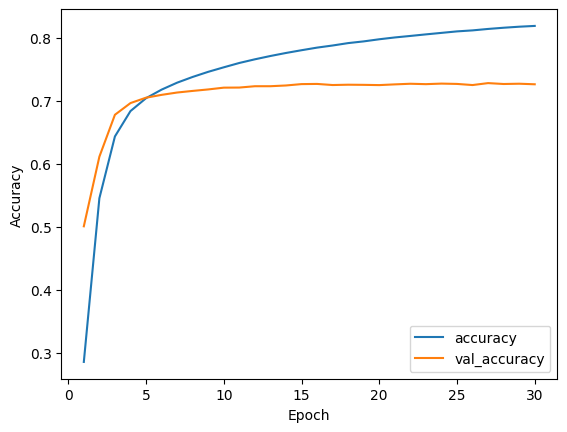

In [30]:
acc=history.history['masked_accuracy']
val_acc=history.history['val_masked_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [40]:
#nog even testen
import numpy as np
import random
fy_vocab = frisian_text_vectorization.get_vocabulary()
fy_index_lookup = dict(zip(range(len(fy_vocab)), fy_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = dutch_text_vectorization([input_sentence])
    decoded_sentence = START_TOKEN
    indices = []

    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence: tf.Tensor = frisian_text_vectorization([decoded_sentence])
        tokenized_target_sentence = tokenized_target_sentence[:, :-1]
        predictions = model([tokenized_input_sentence, tokenized_target_sentence])

        # Pak altijd de laatste voorspelling
        sampled_token_index = np.argmax(predictions[0, i, :])
        indices.append(sampled_token_index)

        sampled_token = fy_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == END_TOKEN:
            break

    return decoded_sentence

def clean(str: str) -> str:
    return str.lower().replace(START_TOKEN + ' ', '').replace(' ' + END_TOKEN, '').replace('[unk]', '?')

for _ in range(10):
    input_sentence, daadwerkelijk = random.choice(list(test_pairs.values))
    print("-----------------------------------------------------------")
    print("NL:", input_sentence)
    print("FY:", clean(daadwerkelijk))
    print("AI:", clean(decode_sequence(input_sentence)))


-----------------------------------------------------------
NL: de australische wilhelmina van der heijden geen familie die toen in de kost was bij onze achterburen van e leende het me
FY: de australise wilhelmina van der heijden gjin famylje dyt doe yn e kost wie by us efterbuorlju van e liende it my
AI: de australyske ? van der ? gjin famylje dyt doe yn de kost wie by us ? fan de
-----------------------------------------------------------
NL: de besnijdenis geldt als een teken een beeld van de uitsnijding van de zonde
FY: de besnijenis jildt as in teken in byld fan it fan de sunde
AI: de ? jildt as in teken in byld fan de fan de skande
-----------------------------------------------------------
NL: ik at slecht en slapen ging niet veel beter
FY: ik iet net en it sliepen gie net folle better
AI: ik iet min en sliepen gie net folle better
-----------------------------------------------------------
NL: zij makelen en schakelen tussen de vraag van gezinnen en het beschikbare hulpaanbod
F

## Meer opties
|Probeersel         |Berendering                        |Effect
|-                  |-                                  |-
`warmup_steps` van 4000 naar 8000 te doen|Ik zag dat het model op stap 1 bijvoorbeeld een veel hogere gevalideerde accuraatheid had|De gevalideerde accuraatheid bleek een tikje lager hiermee.


In [ ]:
embed_dim = 128
dense_dim = 1024
num_heads = 8


encoder_inputs = keras.Input(shape=(dutch_maxlen,), dtype="int64", name="dutch")
decoder_inputs = keras.Input(shape=(frisian_maxlen,), dtype="int64", name="frisian")

# encoder_embedding = TokenAndPositionEmbedding(dutch_vocab_size, dutch_maxlen, embed_dim)(encoder_inputs)
encoder_embedding = PositionalEmbedding(dutch_maxlen, dutch_vocab_size, embed_dim, name="encoder_embedding")(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads, name="encoder_outputs")(encoder_embedding)


# decoder_embedding = TokenAndPositionEmbedding(frisian_vocab_size, frisian_maxlen, embed_dim)(decoder_inputs)
decoder_embedding = PositionalEmbedding(frisian_maxlen, frisian_vocab_size, embed_dim, name="decoder_embedding")(decoder_inputs)
decoder = TransformerDecoder(embed_dim, dense_dim, num_heads, name="decoder")(decoder_embedding, encoder_outputs)


decoder_dropout = layers.Dropout(0.3, name="decoder_dropout")(decoder)
decoder_outputs = layers.Dense(frisian_vocab_size, activation="softmax", name="decoder_outputs")(decoder_dropout)


model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

learning_rate = CustomSchedule(embed_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

model.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

history = model.fit(train_ds, epochs=30, validation_data=test_ds)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'encoder_outputs' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/30
INFO:tensorflow:Converted call: <function TensorFlowTrainer.make_train_function.<locals>.one_step_on_iterator at 0x7efce0464360>
    args: (<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7efce05d0390>,)
    kwargs: {}

INFO:tensorflow:Converted call: <function TensorFlowTrainer.make_train_function.<locals>.one_step_on_data at 0x7efce04640e0>
    args: (({'dutch': <tf.Tensor 'data:0' shape=(None, None) dtype=int64>, 'frisian': <tf.Tensor 'data_1:0' shape=(None, None) dtype=int64>}, <tf.Tensor 'data_2:0' shape=(None, None) dtype=int64>),)
    kwargs: {}



/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/ke

INFO:tensorflow:Converted call: <function TensorFlowTrainer.make_train_function.<locals>.one_step_on_data at 0x7efce04640e0>
    args: (({'dutch': <tf.Tensor 'data:0' shape=(None, None) dtype=int64>, 'frisian': <tf.Tensor 'data_1:0' shape=(None, None) dtype=int64>}, <tf.Tensor 'data_2:0' shape=(None, None) dtype=int64>),)
    kwargs: {}



W0000 00:00:1728855973.292901   25118 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1221/2174 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 8.8266 - masked_accuracy: 0.0650

W0000 00:00:1728855993.211105   25117 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2174/2174 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.0465 - masked_accuracy: 0.1041INFO:tensorflow:Converted call: <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x7efcc0108720>
    args: (<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7efce0273b90>,)
    kwargs: {}

INFO:tensorflow:Converted call: <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_data at 0x7efcc0108680>
    args: (({'dutch': <tf.Tensor 'data:0' shape=(None, None) dtype=int64>, 'frisian': <tf.Tensor 'data_1:0' shape=(None, None) dtype=int64>}, <tf.Tensor 'data_2:0' shape=(None, None) dtype=int64>),)
    kwargs: {}



W0000 00:00:1728856010.017144   25114 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1728856013.242195   25116 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2174/2174 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - loss: 8.0458 - masked_accuracy: 0.1042 - val_loss: 4.6477 - val_masked_accuracy: 0.3936
Epoch 2/30
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 4.4175 - masked_accuracy: 0.4319 - val_loss: 3.3495 - val_masked_accuracy: 0.5549
Epoch 3/30
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 3.4052 - masked_accuracy: 0.5591 - val_loss: 2.8081 - val_masked_accuracy: 0.6166
Epoch 4/30
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 2.8682 - masked_accuracy: 0.6157 - val_loss: 2.4781 - val_masked_accuracy: 0.6615
Epoch 5/30
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 2.4799 - masked_accuracy: 0.6636 - val_loss: 2.2712 - val_masked_accuracy: 0.6888
Epoch 6/30
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 2.2383 - masked_accuracy: 0.6941 - val_loss: 2.1741 - val_masked_accuracy: 0.7017
Epoch 7/30
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 2.0947 - masked_accuracy: 0.7110 - val_loss: 2.1248 - val_masked_accura

 572/2174 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 1.7040 - masked_accuracy: 0.7623

## 5. Evaluation

Tekst

## 6. Deployment

Tekst